In [9]:
import plotly.graph_objects as go
import seaborn as sns
import pandas as pd
import numpy as np
import os
from sentence_transformers import SentenceTransformer
import umap
from scipy import interpolate
from capo.analysis.utils import get_results

from IPython.display import Image

In [26]:
def plot_prompt_embs(dataset, optims, model, seed=42, path_prefix="../"):
    # check if path already exists
    path = f"{path_prefix}/vis_emb/{dataset}_{model}_{seed}/embs.npy"
    dfs = []
    for optimizer in optims:
        df = get_results(dataset, model, optimizer)
        df = df.sort_values(by=["step", "test_score"])
        df = df.drop_duplicates(subset=["prompt"])
        df = df.assign(optim=optimizer)
        dfs.append(df)
    df = pd.concat(dfs)
    if os.path.exists(path):
        embs_2d = np.load(path)
    else:
        embedder = SentenceTransformer("BAAI/bge-m3")
        dim_reducer = umap.UMAP(n_neighbors=15, n_components=2, metric="cosine")

        df["clean_prompt"] = (
            df["prompt"].str.split(r"\[Question\]|Input:").apply(lambda x: x[0]).str.strip()
        )
        embs = embedder.encode(df["clean_prompt"].values)
        embs_2d = dim_reducer.fit_transform(embs)

        # write to path
        os.makedirs(os.path.dirname(path), exist_ok=True)
        np.save(path, embs_2d)

    df["x1"] = embs_2d[:, 0]
    df["x2"] = embs_2d[:, 1]

    df_plot = df.copy()
    df_plot = df_plot[df_plot["step"] != 1]
    df_plot = df_plot[df_plot["seed"] == seed]

    # build grid via interpolation
    x = np.linspace(df_plot["x1"].min(), df_plot["x1"].max(), 100)
    y = np.linspace(df_plot["x2"].min(), df_plot["x2"].max(), 100)
    X, Y = np.meshgrid(x, y)
    Z = interpolate.griddata(
        (df_plot["x1"], df_plot["x2"]), df_plot["test_score"], (X, Y), method="cubic"
    )

    fig = go.Figure()
    # Add contour plot
    fig.add_trace(
        go.Contour(
            z=Z,
            x=X,
            y=Y,
            contours=dict(
                coloring="heatmap",
                showlabels=False,
            ),
            colorscale="Spectral",
            showscale=True,
            opacity=0.9,
        )
    )
    marker_symbols = ["circle", "star"]
    colors = sns.color_palette("Dark2").as_hex()
    for i, category in enumerate(df["optim"].unique()):
        category_df = df[df["optim"] == category]

        fig.add_trace(
            go.Scatter(
                x=category_df["x1"],
                y=category_df["x2"],
                mode="markers",
                hoverinfo="text",
                text=category_df.index,
                marker=dict(
                    symbol=[
                        "star" if idx == category_df["test_score"].idxmax() else "circle"
                        for idx in category_df.index
                    ],
                    # make bigger if it's the best prompt
                    size=[
                        20 if idx == category_df["test_score"].idxmax() else 8
                        for idx in category_df.index
                    ],
                    color=colors[i],
                    line=dict(width=1, color="black"),
                    opacity=[
                        1 if idx == category_df["test_score"].idxmax() else 1
                        for idx in category_df.index
                    ],
                ),
                name=category,
                showlegend=True,
            )
        )
    fig.update_layout(
        height=800,
        width=800,
        legend=dict(itemsizing="constant", xanchor="left", yanchor="bottom", orientation="v"),
        plot_bgcolor="white",
        paper_bgcolor="white",
        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False, showline=False),
        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False, showline=False),
        margin=dict(l=0, r=0, t=0, b=0),
    )
    return Image(fig.to_image(format="png", scale=1, width=800, height=600, engine="orca"))

In [27]:
display(
    plot_prompt_embs(
        dataset, ["CAPO", "EvoPromptGA", "OPRO", "PromptWizard", "init"], model, seed=seed
    )
)

ValueError: 
The image request was rejected by the orca conversion utility
with the following error:
   525: plotly.js error


In [ ]:
for dataset in ["gsm8k", "agnews", "sst-5", "subj", "copa"]:
    for model in ["llama", "qwen", "mistral"]:
        for seed in [42, 43, 44]:
            try:
                plot_prompt_embs(
                    dataset,
                    ["CAPO", "EvoPromptGA", "OPRO", "PromptWizard", "init"],
                    model,
                    seed=seed,
                ).show()
            except:
                print(f"Failed for {dataset}_{model}_{seed}")

Failed for gsm8k_llama_42
Failed for gsm8k_llama_43
Failed for gsm8k_llama_44
Failed for gsm8k_qwen_42
Failed for gsm8k_qwen_43
Failed for gsm8k_qwen_44
Failed for gsm8k_mistral_42
Failed for gsm8k_mistral_43
Failed for gsm8k_mistral_44
Failed for agnews_llama_42
Failed for agnews_llama_43
Failed for agnews_llama_44
Failed for agnews_qwen_42
Failed for agnews_qwen_43
Failed for agnews_qwen_44


In [ ]:
from capo.analysis.visualizations import plot_few_shot_boxplots

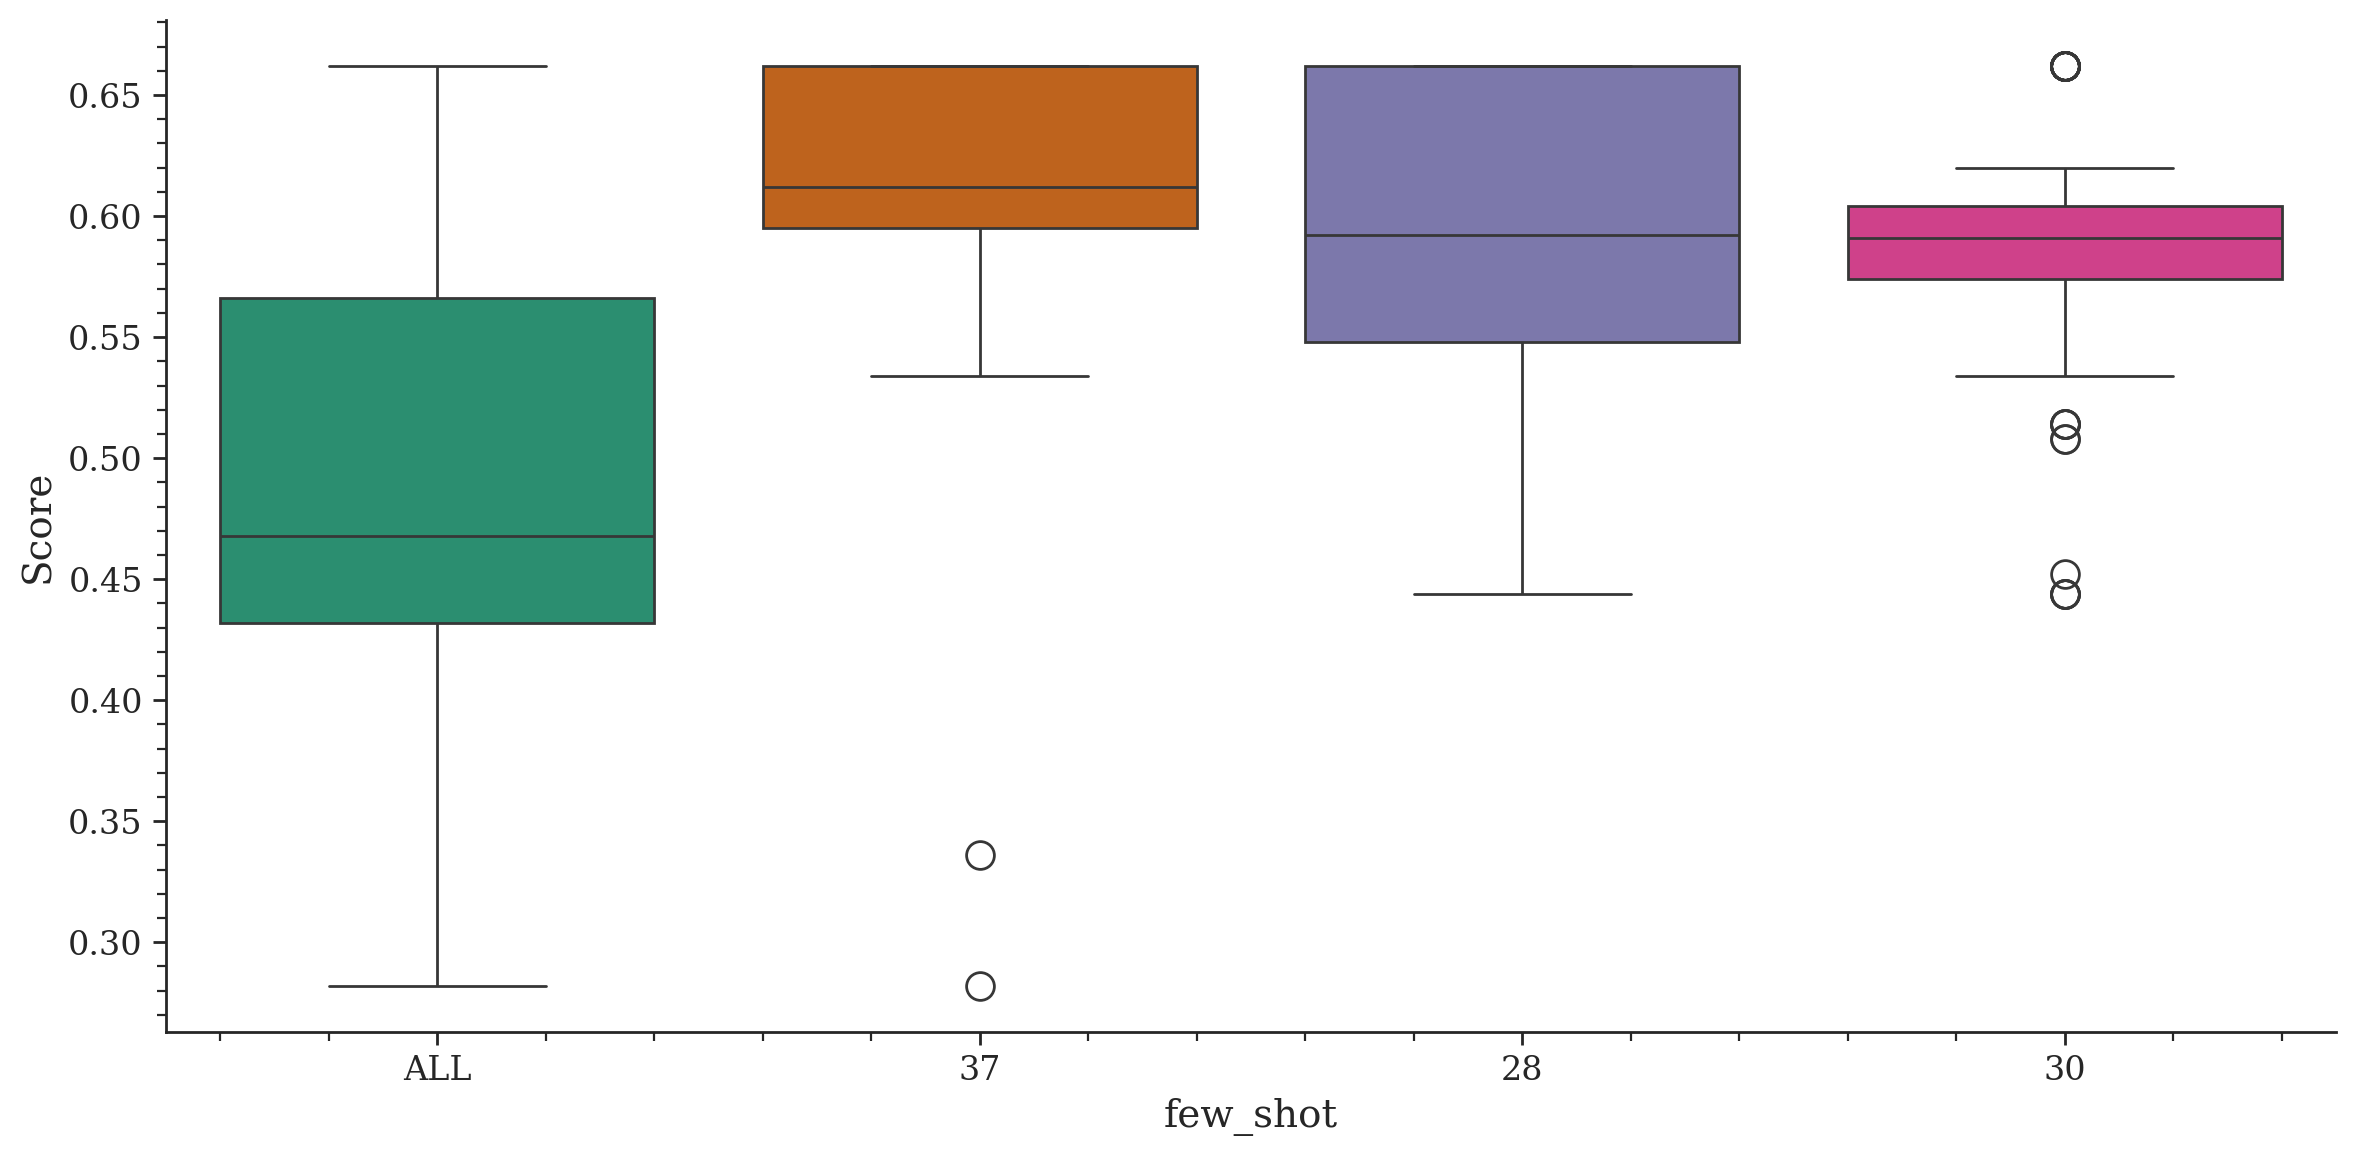

In [ ]:
plot_few_shot_boxplots("gsm8k", "qwen", "CAPO")